# APRENDIZAJE AUTOMÁTICO
# Práctica 1: Regresión
### Autor: Jiménez Omeñaca, David
### NIP:   825068
### Fecha: 10-02-2025
---



## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = 'data/'                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos
Comenzamos cargando y analizando los datos disponibles.

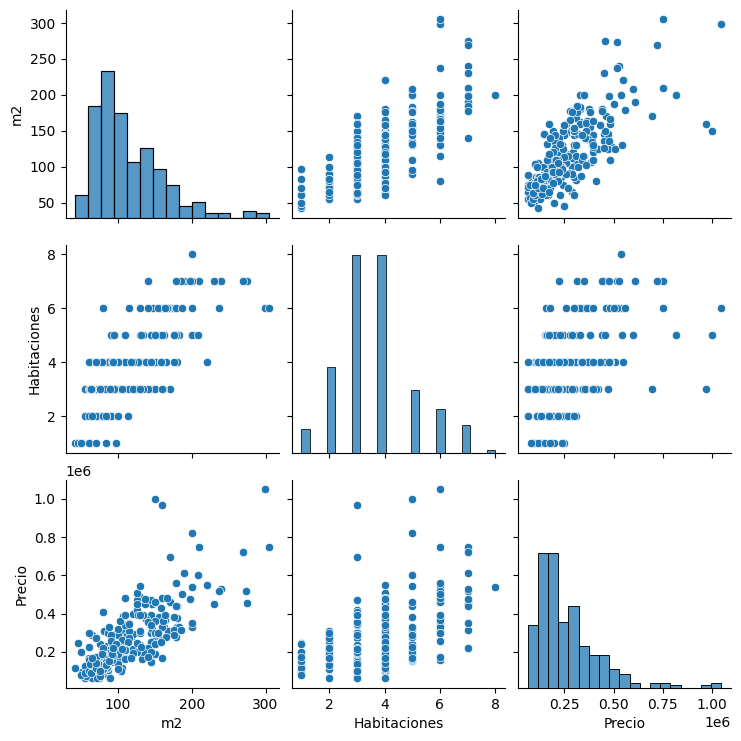

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Leer los ficheros de datos y pasarlos a matrices de numpy
pisos_train = pd.read_csv(Path+'PisosTrain.csv', sep = ";")

# Reshape it to a 2D array with 1 column
x1_train = pisos_train["m2"].to_numpy().reshape(-1, 1)
x2_train = pisos_train["Habitaciones"].to_numpy().reshape(-1, 1)

# Not needed the reshape.
y_train  = pisos_train["Precio"].to_numpy()

pisos_test  = pd.read_csv(Path+'PisosTest.csv',  sep = ";")
x1_test = pisos_test["m2"].to_numpy().reshape(-1, 1)
x2_test = pisos_test["Habitaciones"].to_numpy().reshape(-1, 1)

# Not needed the reshape
y_test  = pisos_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(pisos_train)
plt.show()


Ahora ploteamos cada una de las variables con respecto a la variable explicada (precio) para analizar la posibilidad de datos espurios u otro tipo de anomalías.

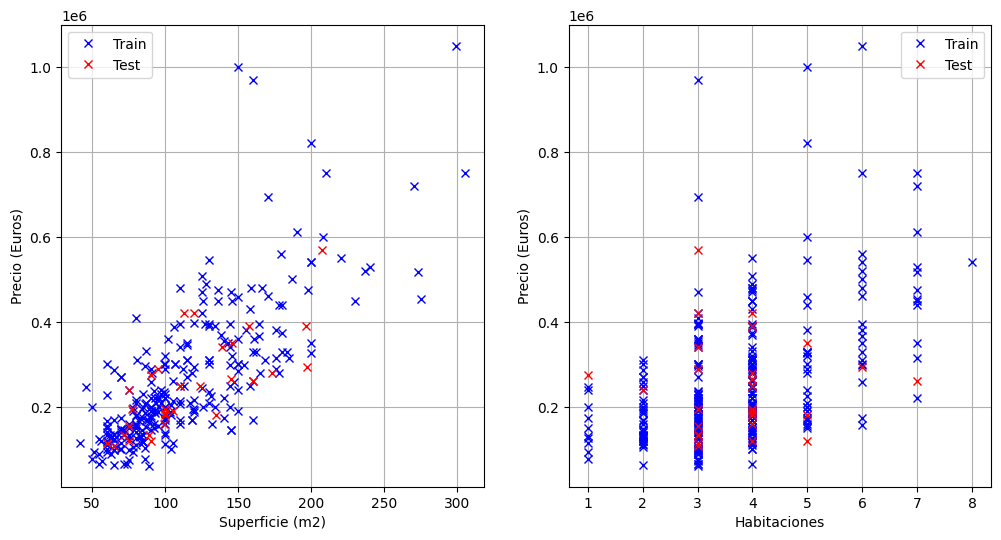

In [3]:
plt.figure(figsize=(12, 6))

# First plot
plt.subplot(1, 2, 1)
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test, 'rx', label='Test')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()

# Second plot
plt.subplot(1, 2, 2)
plt.plot(x2_train, y_train, 'bx', label='Train')
plt.plot(x2_test, y_test, 'rx', label='Test')
plt.xlabel('Habitaciones')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()

plt.show()

Observamos una tendencia creciente del precio respecto a la superficie y número de habitaciones (como era de esperar). Además, podemos ver la existencia de ciertos **datos espureos** en la primera gráfica, luego habrá que trabajar consecuentemente.

---
## 1. Métricas

Como en el apartado anterior, hemos detectado una pequeña cantidad de datos espureos, vamos a utilizar las medidas **MAE**, **MRE** y por defecto, la medida $R^2$. Para ello, creamos una clase que calcule las diferentes medidas de error (llamada `ErrorMetrics`). La mayoría de ellas se pueden calcular directamente desde el módulo `sklearn` pero con fines prácticos, se van a implementar de 0. También se crea una clase `Models` para almacenar los diferentes modelos creados.

In [4]:
from enum import IntFlag
from sklearn.metrics import r2_score
import pandas as pd
from typing import Dict

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ErrorMetricsFlags(IntFlag):
    """
    Class to represent which error metrics to compute in a Linear Regression 
    analysis.

    It supports:

    - **RMSE**: Root Mean Squared Error 
    - **MAE**: Mean Absolute Error
    - **MedAE**: Median Absolute Error
    - **MRE**: Mean Relative Error
    - **MedRE**: Median Relative Error
    - **R2**: Coefficient of Determination (R^2)
    """

    RMSE = 1 << 0
    MAE = 1 << 1
    MedAE = 1 << 2
    MRE = 1 << 2
    MedRE = 1 << 3
    R2 = 1 << 4


class ErrorMetrics():
    """
    A class to compute various error metrics for model evaluation.
    """

    def __init__(self, y_real:np.ndarray, y_pred:np.ndarray) -> None:
        """
        Initializes the ErrorMetrics class with the real and predicted values.

        Parameters
        ----------

        y_real (np.ndarray) : The real values of the target variable.
        y_pred (np.ndarray) : The predicted values of the target variable.

        """
        self.y_real = y_real
        self.y_pred = y_pred
        self.n = y_real.shape[0]
    def RMSE(self) -> float:
        """ 
        Function to compute the Root Mean Squared Error (RMSE) of the model.
        """
        return np.sqrt(1/self.n*np.sum(np.pow((self.y_pred-self.y_real),2)))
    def MAE(self) -> float:
        """
        Function to compute the Mean Absolute Error (MAE) of the model.
        """
        return 1.0/self.n*sum(np.abs(self.y_pred-self.y_real))
    def MedAE(self) -> float:
        """ 
        Function to compute the Median Absolute Error (MedAE) of the model.
        """
        return np.median(np.abs(self.y_pred-self.y_real))
    def MRE(self) -> float:
        """
        Function to compute the Mean Relative Error (MRE) of the model.
        """
        return 1/self.n*np.sum(np.abs(self.y_pred-self.y_real)/self.y_real)
    def medRE(self) -> float:
        """
        Function to compute the Median Relative Error (MedRE) of the model.
        """
        return np.mean(np.abs(self.y_pred-self.y_real)/self.y_real)
    def R2(self) -> float:
        """
        Function to compute the Coefficient of Determination (R^2) of the model.
        """
        a = (self.y_real-self.y_pred).transpose() @ (self.y_real-self.y_pred)
        b = (self.y_real-np.mean(self.y_real)).transpose() @ (self.y_real-np.mean(self.y_real))
        return 1-a/b
    
    def compute_metrics(self, flags:ErrorMetricsFlags, name:str, r:int) -> Dict[str, float]:
        """
        Function to compute multiple error metrics at once.

        Parameters
        ----------

        flags (ErrorMetricsFlags) : The flags indicating which metrics to compute.
        name (str) : The name of the model.

        Returns
        -------

        dict (Dict[str, float]) : A dictionary containing the computed metrics (given by the activated flags).
        """
        dic_ = {
            f'RMSE_{name}': [round(self.RMSE(), r)] if flags & ErrorMetricsFlags.RMSE else [],
            f'MAE_{name}': [round(self.MAE(), r)] if flags & ErrorMetricsFlags.MAE else [],
            f'MedAE_{name}': [round(self.MedAE(), r)] if flags & ErrorMetricsFlags.MedAE else [],
            f'MRE_{name}': [round(self.MRE(), r)] if flags & ErrorMetricsFlags.MRE else [],
            f'MedRE_{name}': [round(self.medRE(), r)] if flags & ErrorMetricsFlags.MedRE else [],
            f'R2_{name}': [round(self.R2(), r)] if flags & ErrorMetricsFlags.R2 else []
        }
        return dic_

# Create a empty models
models = Models()

# Create wanted flags
flags = ErrorMetricsFlags.MAE | ErrorMetricsFlags.MRE | ErrorMetricsFlags.R2

Finalmente, creamos una clase para calcular las métricas de un modelo concreto.

In [5]:
from sklearn.linear_model import LinearRegression
class LinearRegression:
    """
    Class to represent a Linear Regression model which can be trained and evaluated.
    """
    def __init__(   self, train_x:np.ndarray, train_y:np.ndarray,
                    test_x:np.ndarray, test_y:np.ndarray, model, name:str,
                    metrics:ErrorMetricsFlags, opt_name=None):
        """
        Initializes the LinearRegression class with the training and testing data.

        Parameters
        ----------
        train_x (np.ndarray) : The training input data.
        train_y (np.ndarray) : The training target data.
        test_x (np.ndarray) : The testing input data.
        test_y (np.ndarray) : The testing target data.
        model : The model to be trained.
        name (str) : The name of the model.
        metrics (ErrorMetricsFlags) : The error metrics to compute.
        opt_name (str, optional) : The name of the optimizer if the model \
        is given by a pipeline. Defaults to None.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.model = model
        self.name = name
        self.metrics = metrics

        # Fit the model
        self.model.fit(self.train_x, self.train_y)

        # Get the weights and intercept. If it is a neural network, set it to 0
        try:
            # If it is a pipeline, get it from the optimizer name.
            if hasattr(self.model, 'named_steps'):
                self.intercept_ = self.model.named_steps[opt_name].intercept_
                self.coef_ = self.model.named_steps[opt_name].coef_
            # if not, get it from the model itself
            else:
                self.intercept_ = self.model.intercept_
                self.coef_ = self.model.coef_
            
            # If it is a numpy array with one element, get the first element
            if isinstance(self.intercept_, np.ndarray):
                self.intercept_ = self.intercept_[0]
        except:
            # For Neural Networks models
            self.intercept_ = 0
            self.coef_ = 0

    def get_weights(self, r=2):
        """
        Function to get the weights of the model.
        
        Parameters
        ----------

        r (int, optional) : The number of decimals to round the weights. Defaults to 2.
        """
        return [round(float(self.intercept_), r)] + [round(float(x) , r) for x in self.coef_]
    

    def plot_model(self, x_index, xlabel, ylabel):
        """
        Plot the model given the index of the variable to plot in the x-axis.

        Parameters
        ----------
        x_index (int) : The index of the variable to plot in the x-axis.
        xlabel (str) : The label of the x-axis.
        ylabel (str) : The label of the y-axis.


        """
        
        # Create a two col figure
        plt.figure(figsize=(12, 6))
        
        # Get variable given the index
        x_test = self.test_x[:,x_index].reshape(-1,1)
        x_train = self.train_x[:,x_index].reshape(-1,1)

        # --------------------------
        # Train plot

        # Create a grid to plot a line
        x_grid_train = np.zeros(shape=(100,self.test_x.shape[1])) 
        x_grid_train[:,x_index] = np.linspace(np.min(x_train), np.max(x_train), 100)
        y_grid_train = self.model.predict(x_grid_train)

        
        plt.subplot(1,2,1)
        plt.plot(x_train, self.train_y, 'bx', label='Train')
        plt.plot(x_grid_train, y_grid_train, 'k-', label="Pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

        # --------------------------
        # Test plot

        # Create a grid to plot a line
        x_grid_test = np.linspace(np.min(x_test), np.max(x_test), 100).reshape(-1, 1)
        y_grid_test = self.model.predict(x_grid_train)

        plt.subplot(1,2,2)
        plt.plot(x_test, y_test, 'bx', label='Test')
        plt.plot(x_grid_test, y_grid_test, 'k-', label="Pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    def pretty_print(self, r=2):
        """
        
        Function to print the model in a pretty way (markdown).

        Parameters
        ----------

        r (int, optional) : The number of decimals to round the weights. Defaults to 2.


        """
        from IPython.display import display, Markdown
        all_variables = "+".join([f" ({round(x, r)}) \\cdot x_{i+1} " for (i,x) in enumerate(self.coef_)])
        all_line = f"$$\\hat{{y}} = {round(self.intercept_, r)} +" + all_variables + " $$"
        display(Markdown(all_line))
    

    def plot_pred_vs_real(self, title=""):

        """
        Function to plot the predicted vs real values of the model.
        It also plots the line y=x.

        Parameters
        ----------

        title (str, optional) : The title of the plot. Defaults to "".
        """
        plt.figure()

        plt.plot(self.test_y, self.model.predict(self.test_x), 'bx', label="Test")
        plt.plot(self.train_y, self.model.predict(self.train_x), 'gx', label="Train")

        # Create a grid to plot a line
        all_values = np.concat([self.test_y,self.train_y],axis=0)
        x_grid = np.linspace(np.min(all_values), np.max(all_values), 100).reshape(-1, 1)
        plt.plot(x_grid, x_grid, 'k-', label='y=x')

        plt.xlabel("Real")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.legend()
        plt.grid()

    def compute_metrics(self, r=2):

        """
        Function to compute the metrics of the model.

        Parameters
        ----------
        r (int, optional) : The number of decimals to round the metrics. Defaults to 2.

        Returns
        -------

        pd.DataFrame : A DataFrame containing the computed metrics.
        """

        y_train_predicted = self.model.predict(self.train_x)
        y_test_predicted = self.model.predict(self.test_x)

        # Compute the metrics for training
        em_train = ErrorMetrics(y_train, y_train_predicted)
        metrics_train = em_train.compute_metrics(self.metrics, "train", r)

        em_test = ErrorMetrics(y_test, y_test_predicted)
        metrics_test = em_test.compute_metrics(self.metrics, "test", r)

        metrics = {"Name":self.name,**metrics_train, **metrics_test}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)

----
## 2. Regresión Monovariable

Para este primer apartado, vamos a utilizar un modelo de **regresión monovariable**, para predecir el precio de los pisos en función de sus supercicie, utilizando la ecuación normal. Es decir, tenemos $X\in \mathbb{M}^{n\times 2}$ donde $n$ es el número de muestras, $X = [\mathbf{1}, X_{sup}]$ y suponemos $\hat{y} = Xw$ donde $w\in\mathbb{R}^n$ es un vector de pesos. Así, la ecuación normal nos da los valores de estos pesos que minimizan el error cuadrado $(y-\hat{y})^T(y-\hat{y})$:
$$
w = (X^TX)^{-1}X^Ty
$$
Los valores $\hat{y}$ se puede interpretar como la proyección de $y$ sobre el subespacio $\{\mathbf{1}, X_{sup}\}$ (ver sección **11.2.2.1** de [*Probabilistic Machine Learning: An Introduction*](https://probml.github.io/pml-book/book1.html)).

Esta solución es analítica y se puede calcular de dos formas equivalentes:
- Obteniendo la solución lineal del sistema:
$$
(X^TX)w = X^Ty
$$
- Utilizando la función `LinearRegression()` de `scikit-learn`

Comenzamos obteniendo la solución del sistema usando `numpy.linalg.solve`.

In [6]:
# Code to compute manually the weights using the normal equation

n = x1_train.shape[0]
X_ = np.concat([np.ones((n,1)), x1_train], axis=1)

w = np.linalg.solve(X_.transpose() @ X_, X_.transpose() @ y_train)

print("Weights : ", w)

Weights :  [-34313.38797202   2608.20943472]


Veamos que sale los mismos valores usando la función de librería

In [7]:
from sklearn import linear_model

one_variable_model = LinearRegression(  x1_train, y_train, 
                                        x1_test, y_test, 
                                        linear_model.LinearRegression(),
                                        "One-Variable", flags)
models.append(one_variable_model.compute_metrics())
one_variable_model.get_weights(r=10)


[-34313.3879720236, 2608.2094347218]

Así, ambos resultados son idénticos. Entonces la recta resultante es:

In [8]:
one_variable_model.pretty_print(r=0)

$$\hat{y} = -34313.0 + (2608.0) \cdot x_1  $$

La ploteamos junto a los datos de entrenamiento y test:

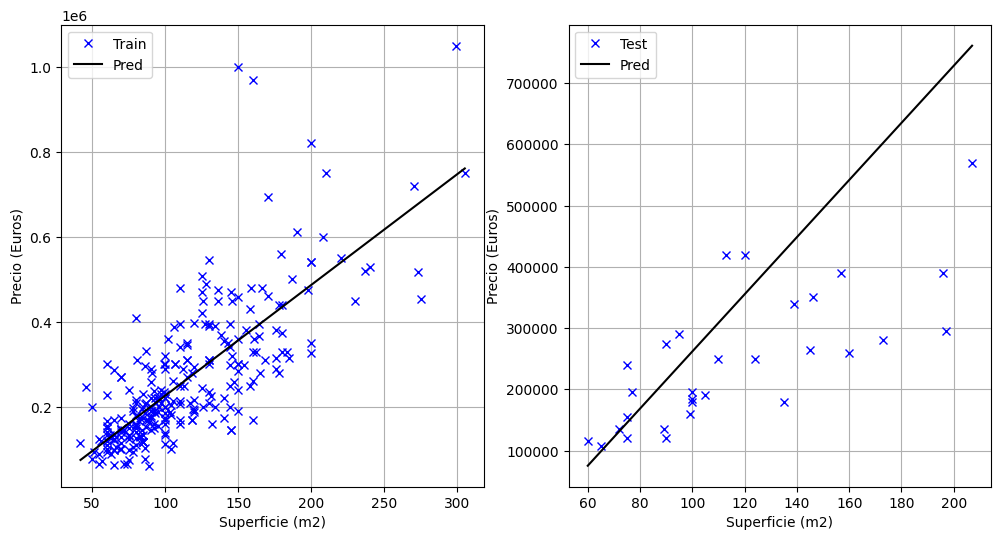

In [9]:
one_variable_model.plot_model(0, 'Superficie (m2)', 'Precio (Euros)')

Además, para un análisis cuantitativo, calculamos las métricas de error para datos de training y de test.

In [10]:
one_variable_model.compute_metrics(r=2)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,One-Variable,69534.93,50507.31,0.3,0.58,63936.47,56182.93,0.27,0.46


Aquí podemos ver que el ajuste no es muy bueno ya que se tiene un $R^2$ relativamente bajo para los datos de test.

----
## 3. Regresión Multivariable
Ahora vamos a explicar el precio en función de la superficie y el número total de habitaciones. Vamos a aplicar también la fórmula normal pero ahora $X = [\mathbf{1}, X_{sup}, X_{hab}] \in \mathbb{M}^{n\times 3}$. Esta vez, directamente vamos a usar la función de librería. Entonces, la ecuación del plano es :

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
x_train = np.concat([x1_train, x2_train], axis=1)
x_test = np.concat([x1_test, x2_test], axis=1)
two_variables_model = LinearRegression( x_train, y_train, 
                                        x_test, y_test, 
                                        make_pipeline(StandardScaler(),linear_model.LinearRegression()),
                                        "Two-Variables", flags, opt_name="linearregression")
models.append(two_variables_model.compute_metrics())
two_variables_model.pretty_print()

$$\hat{y} = 260244.18 + (141225.45) \cdot x_1 + (-25987.7) \cdot x_2  $$

donde $x_1$ es la superficie y $x_2$ es el número de habitaciones. 

Notar que para esta regresión, se ha aplicado un escalado estándar $X' = \frac{X-\mu(X)}{\sigma(X)}$ a los atributos.

Aquí se aprecia que el número de habitaciones afecta de forma negativa al precio, algo que no parece tener mucho sentido. Sin embargo, esto se debe a que las dos covariables: número de habitaciones y superficie no son independientes (de hecho son muy dependientes), haciendo que el modelo *aumente* el coeficiente de la superficie con respecto al modelo anterior y lo *ajuste* con el número de habitaciones. En efecto, podemos calcular la matriz de correlación de estas dos variables:

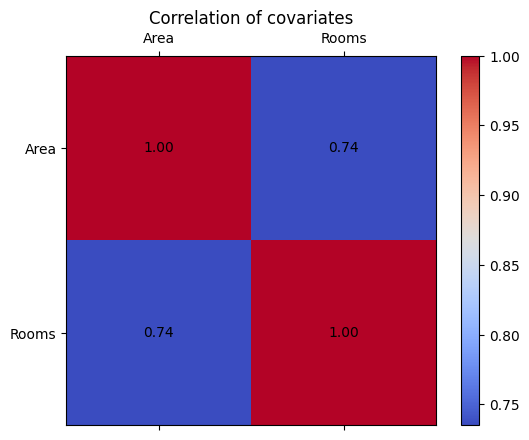

In [12]:
data = np.concatenate([x_test, x_train], axis=0)
corr_matrix = np.corrcoef(data.transpose())

fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='coolwarm')

# Add the value of each cell in text in the center of the cell
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set the ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Area", "Rooms"])
ax.set_yticklabels(["Area", "Rooms"])

# Add a title
plt.title("Correlation of covariates")

plt.colorbar(cax)
plt.show()

con un valor $\sigma_{x_1x_2} =0.74$ muy cercano a $1$. Habría que valorar si la inclusión de ambas variables es necesaria debido a esta gran correlación.

Por otro lado, ploteamos los valores predichos vs los valores reales. Un modelo perfecto se ajustaría perfectamente a la recta $y=x$, por eso la ploteamos conjuntamente.


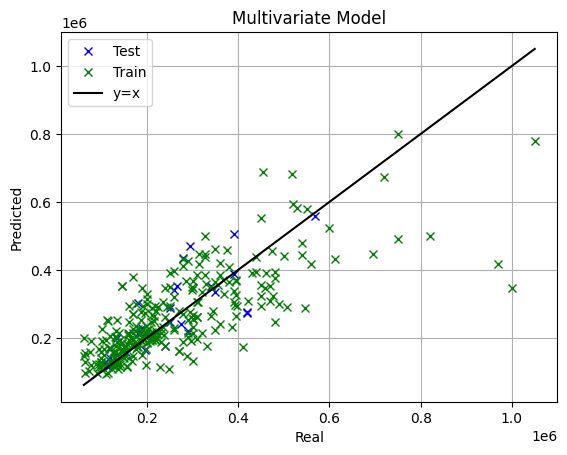

In [13]:
two_variables_model.plot_pred_vs_real("Multivariate Model")

Finalmente, las métricas de este modelo son las siguientes:

In [14]:
two_variables_model.compute_metrics(r=2)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,Two-Variables,69089.3,48215.88,0.3,0.6,55256.44,36675.14,0.23,0.54


Aquí podemos apreciar una ligera mejora del $R^2$ del modelo, indicando que al añadir el número de habitaciones, se ha explicado mejor el precio de la vivienda. 

----
## 4. Regresión Multivariable con Descenso de Gradiente
Ahora vamos a realizar lo mismo que en el apartado anterior pero utilizando la técnica de descenso de gradiente estocástico ( ver apartado 8.4 de [*Probabilistic Machine Learning: An Introduction*](https://probml.github.io/pml-book/book1.html)). 

En este algoritmo se tiene un hiperparámetro $\alpha$ llamado *learning rate* o **tasa de aprendizaje** que representa cuánto se mueven los pesos respecto a su gradiente en cada iteración. En este caso, usaremos el valor por defecto que se da en la función `SGDRegressor`. Además, también hay que determinar qué función de coste se va a usar. En nuestro caso, se va a utilizar la función de mínimos cuadrados.

In [15]:
from sklearn.linear_model import SGDRegressor


model_SGD = make_pipeline(StandardScaler(), SGDRegressor(alpha=0,max_iter=100000, penalty=None) )

SGD_model = LinearRegression(x_train, y_train, 
                             x_test, y_test, model_SGD, 
                             "SGD-multivariate", flags, 
                             opt_name='sgdregressor')
models.append(SGD_model.compute_metrics())

SGD_model.pretty_print()

$$\hat{y} = 260169.3 + (139429.15) \cdot x_1 + (-24494.82) \cdot x_2  $$

Notar que para esta regresión, se ha aplicado también un escalado estándar, como se recomienda en la guía oficial de [**scikit-learn**](https://scikit-learn.org/stable/index.html). Para comprobar los resultados, vamos a plotear la gráfica de predichos vs reales:

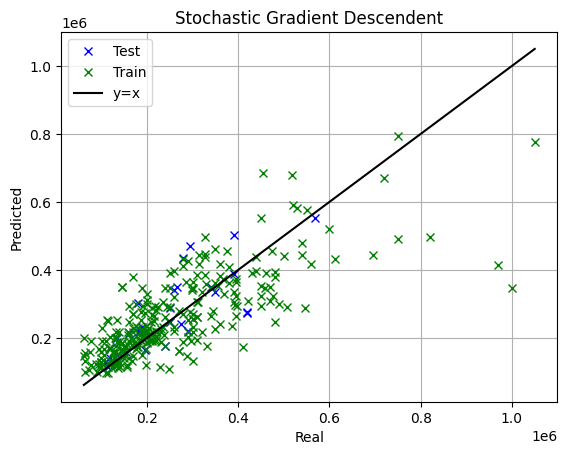

In [16]:
SGD_model.plot_pred_vs_real("Stochastic Gradient Descendent")

También podemos imprimir las medidas de error obtenidas:

In [17]:
SGD_model.compute_metrics()

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,SGD-multivariate,69005.42,48348.54,0.3,0.59,55611.65,36965.89,0.23,0.54


obteniendo un valor casi idéntico al obtenido en el método de regresión multivariable. Esto se debe a que esta función de error solo tiene un mínimo absoluto, haciendo que el método de SGD siempre converga a este. Esto también se aprecia en los parámetros que son muy parecidos.

In [18]:
two_variables_model.compute_metrics()

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,Two-Variables,69089.3,48215.88,0.3,0.6,55256.44,36675.14,0.23,0.54


----
## 5. Regresión Multivariable con Descenso de Gradiente y coste de Huber
En este apartado, vamos a utilizar una distinta función de coste para tratar con los datos espureos. Esta nueva función le da menos peso a los valores que están a una distancia mayor que un valor $\delta$. Si se usa la función `HuberRegressor`, este valor se fija a $\delta = \epsilon \cdot \sigma_Y $ con $\epsilon=1.35$ por defecto, suponiendo que los datos correctos se desvían como mucho de esa desviación típica. Otra opción, es utilizar la función de pérdida `loss=Huber` en un modelo `SGDRegressor`. En este caso, tendremos que ajustar nosotros el $\delta$ analizando los valores de los datos. Vamos a probar ambas.

Comenzamos utilizando la función `HuberRegressor` con el valor por defecto $\epsilon=1.35$.

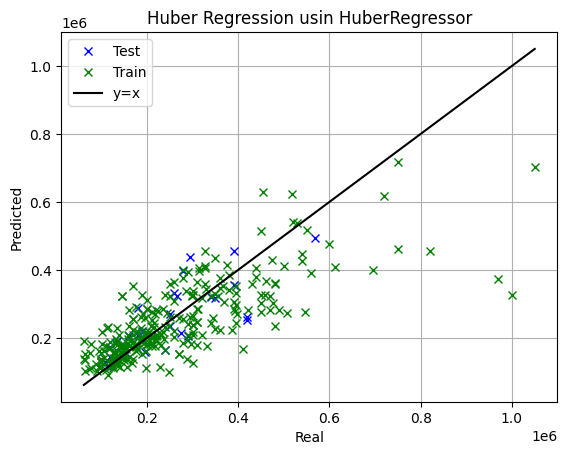

In [19]:
from sklearn.linear_model import HuberRegressor

huber_model_aut = make_pipeline(StandardScaler(), HuberRegressor())

huber_model_1 = LinearRegression(x_train, y_train, 
                                x_test, y_test, huber_model_aut, 
                             "HuberRegressor-Aut", flags, 
                             opt_name='huberregressor')
models.append(huber_model_1.compute_metrics())


huber_model_1.plot_pred_vs_real(title="Huber Regression usin HuberRegressor")



Y las métricas:

In [20]:
huber_model_1.compute_metrics(r=2)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,HuberRegressor-Aut,67934.8,42165.49,0.28,0.58,55158.3,40729.47,0.22,0.58


Aquí vemos un valor $R^2$ en los datos de test de $0.58$, mejorando un poco los resultados obtenidos con los realizados con una función de coste cuadrático. Ahora vamos a probar utilizando el segundo método. Para este, vamos a consultar los gráficos realizados al comienzo, viendo que la mayoría de los precios se ajustan entorno a $\pm 200.000 €$. Usaremos este valor como $\delta$.

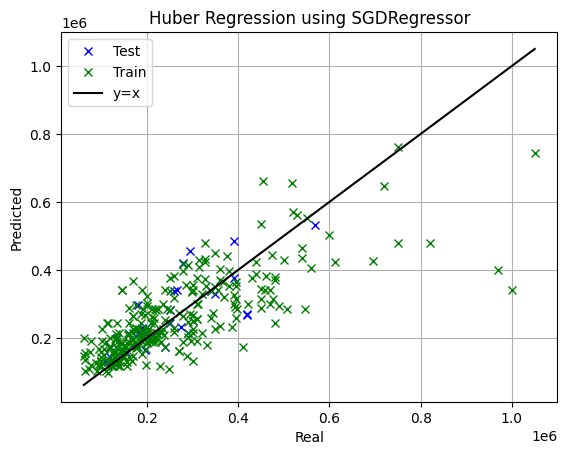

In [21]:
huber_model_not_aut = make_pipeline(StandardScaler(), SGDRegressor(loss="huber",epsilon=2e5))

huber_model_2 = LinearRegression(x_train, y_train, 
                                x_test, y_test, huber_model_not_aut, 
                             "HuberRegressor-NotAut", flags, 
                             opt_name='sgdregressor')
models.append(huber_model_2.compute_metrics())

huber_model_2.plot_pred_vs_real(title="Huber Regression using SGDRegressor")

Las métricas para este nuevo modelo son:

In [22]:
huber_model_2.compute_metrics(r=2)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,HuberRegressor-NotAut,68275.09,46891.23,0.29,0.59,55166.86,38391.35,0.23,0.57


Estas son muy similares a las obtenidas con el método anterior, llegando a conclusiones similares.

----
## 5. Regresión con redes neuronales
En este apartado, vamos a realizar la regresión utilizando redes neuronales. Para ello, vamos a diseñar primero una red sin capa oculta y otra con una capa oculta. Para determinar el número de neuronas de la capa oculta, hay que tener en cuenta cúantas muestras se tienen. En nuestro caso tenemos $n=276$. Para ajustar estos modelos, utilizarmos la función `MLPRegressor` de `sklearn`.

Para el primer modelo sin capa oculta, para su convergencia, se ha tenido que utilizar el optimizador `sgd` debido a que por defecto, el optimizador `adam` para una red tan pequeña como esta (InputLayer:2, OutputLayer:1) no converge. También se ha utilizado la función de activación identidad $y=x$.

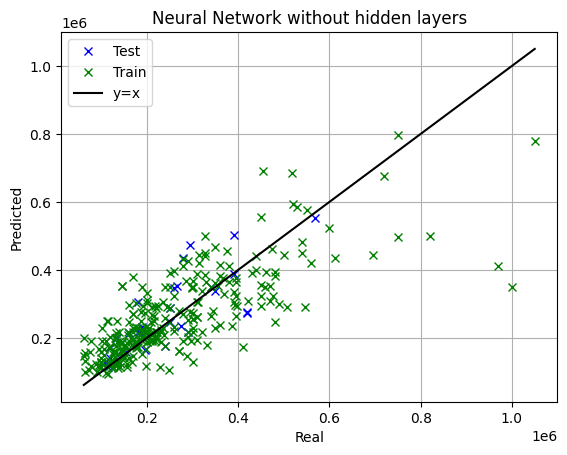

In [23]:
from sklearn.neural_network import MLPRegressor
NN_1 = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(), max_iter=1000, 
                                                    activation="identity", learning_rate="adaptive", solver="sgd"))

NN_1_model = LinearRegression(x_train, y_train, 
                              x_test, y_test, NN_1, 
                             "NeuralNetwork-No-HL", flags, 
                             opt_name='mlpregressor')
models.append(NN_1_model.compute_metrics())

NN_1_model.plot_pred_vs_real("Neural Network without hidden layers")

In [24]:
NN_1_model.compute_metrics()

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,NeuralNetwork-No-HL,68990.44,48248.53,0.3,0.59,56304.56,38098.95,0.24,0.53


Este método es muy similar al obtenido con el `SGD` debido a que el metodo es realmente equivalente (si no hay capa oculta). Esto se puede ver en las métricas que son casi idénticas.

Para el segundo modelo, como $n=276$, vamos a probar con una capa oculta con $128$ neuronas (potencias de dos).

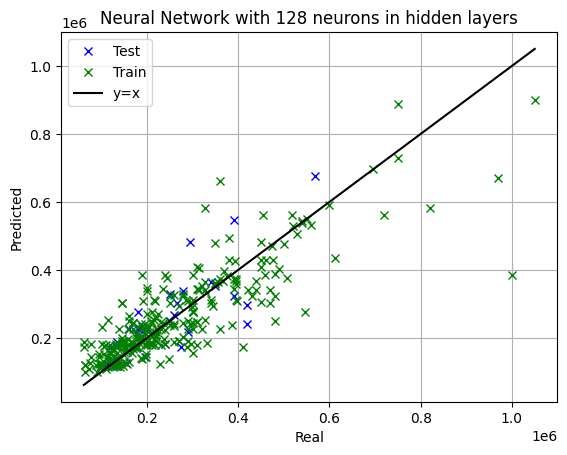

In [25]:
NN_2_128 = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(128), max_iter=10000,  
                                                    solver="lbfgs", activation="relu"))

NN_2_model_128 = LinearRegression(x_train, y_train, 
                              x_test, y_test, NN_2_128, 
                             "NeuralNetwork-Hidden-128", flags, 
                             opt_name='mlpregressor')
models.append(NN_2_model_128.compute_metrics())

NN_2_model_128.plot_pred_vs_real("Neural Network with 128 neurons in hidden layers")

Obtenemos las métricas

In [26]:
NN_2_model_128.compute_metrics()

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,NeuralNetwork-Hidden-128,55096.52,36558.59,0.25,0.72,60427.96,50563.86,0.24,0.49


métricas bastante malas debido a que el problema no muy conveniente para el uso de redes neuronales.

----
## 6. Comparación todos los modelos
Ahora vamos a mostrar todos los modelos ordenados por el $R^2$ de test:

In [27]:
models.sort(by="R2_test", ascending=False)
models.print()

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
3,HuberRegressor-Aut,67934.80,42165.49,0.28,0.58,55158.30,40729.47,0.22,0.58
4,HuberRegressor-NotAut,68275.09,46891.23,0.29,0.59,55166.86,38391.35,0.23,0.57
1,Two-Variables,69089.30,48215.88,0.30,0.60,55256.44,36675.14,0.23,0.54
2,SGD-multivariate,69005.42,48348.54,0.30,0.59,55611.65,36965.89,0.23,0.54
5,NeuralNetwork-No-HL,68990.44,48248.53,0.30,0.59,56304.56,38098.95,0.24,0.53
6,NeuralNetwork-Hidden-128,55096.52,36558.59,0.25,0.72,60427.96,50563.86,0.24,0.49
0,One-Variable,69534.93,50507.31,0.30,0.58,63936.47,56182.93,0.27,0.46


En esta tabla podemos ver que el mejor modelo es el obtenido con la regresión de `Huber` utilizando la función `HuberRegressor`. Por otro lado, se puede apreciar que los modelos de redes neuronales no se adaptan muy bien en este caso. Esto puede ser debido a la naturaleza lineal de los datos o por las pocas muestras que se tienen. Finalmente, como conclusión general, se observa un valor $R^2$ en los datos de test que no supera al valor $0.6$, que se puede considerar bajo. Sin embargo, esto puede ser normal debido a la **variabilidad** innata de los datos, que podría ser explicada a partir de otros **atributos** como podría ser: **renta media** de la localización de la casa, ubicación en zona **rural** o **urbana**, *altitud* de la vivienda (pisos más altos tienden a ser más caros), entre muchos otros factores. 


### Referencias

Murphy, K. P. (2022). *Probabilistic Machine Learning: An Introduction*. MIT Press.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.
